In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!ls

drive  sample_data


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import datetime

Prepare Data

---



In [32]:
# Load data from CSV file
data = pd.read_csv('/content/drive/MyDrive/398402/online_retail_II.csv', encoding='ISO-8859-1')
print(data.shape)

# Drop rows with missing values and duplicates
data = data.dropna()
data = data.drop_duplicates()

# Convert InvoiceDate column to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')

# Encode categorical variables
encoder = LabelEncoder()
data['Country'] = encoder.fit_transform(data['Country'])

encoder = LabelEncoder()
data['StockCode'] = encoder.fit_transform(data['StockCode'])


# Convert InvoiceDate to Unix timestamps
data['InvoiceDate'] = data['InvoiceDate'].apply(lambda x: datetime.datetime.timestamp(x))

## convert Invoice values to binary: Cancellation : 0, Success : 1
data['Invoice'] = data['Invoice'].apply(lambda x: 0 if x[0] == 'C' else 1)

## Remove Description from dataset
data = data.drop('Description', axis=1)

print(data.shape)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('InvoiceDate', axis=1), data['InvoiceDate'], test_size=0.2, random_state=0)

# # Reshape data for CNN
# X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

# # Reshape data for CNN
# X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


## Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(1067371, 8)


<ipython-input-32-5e2370e0ac8f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')


(797885, 7)


MLP

---



Epoch 1/50
3990/3990 [==============================] - 11s 3ms/step - loss: 722894528.0000 - val_loss: 331657088.0000 - lr: 0.0100
Epoch 2/50
3990/3990 [==============================] - 11s 3ms/step - loss: 319530880.0000 - val_loss: 171212672.0000 - lr: 0.0100
Epoch 3/50
3990/3990 [==============================] - 9s 2ms/step - loss: 242719680.0000 - val_loss: 106042136.0000 - lr: 0.0100
Epoch 4/50
3990/3990 [==============================] - 11s 3ms/step - loss: 209207968.0000 - val_loss: 80885224.0000 - lr: 0.0100
Epoch 5/50
3990/3990 [==============================] - 11s 3ms/step - loss: 187924208.0000 - val_loss: 61742812.0000 - lr: 0.0100
Epoch 6/50
3990/3990 [==============================] - 11s 3ms/step - loss: 172110272.0000 - val_loss: 57160104.0000 - lr: 0.0100
Epoch 7/50
3990/3990 [==============================] - 11s 3ms/step - loss: 163547120.0000 - val_loss: 48336400.0000 - lr: 0.0100
Epoch 8/50
3990/3990 [==============================] - 10s 2ms/step - loss: 1579

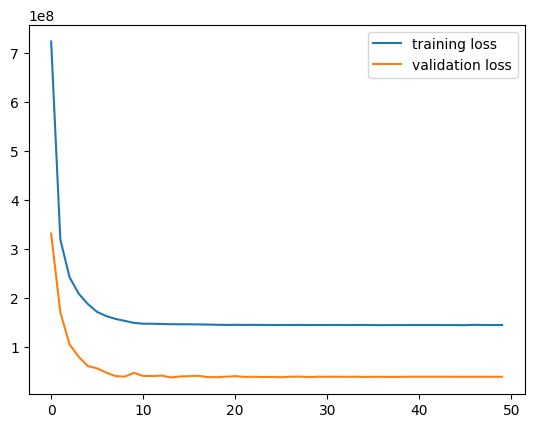

In [33]:
# Define model architecture: MLP

from keras import initializers, regularizers, optimizers

model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.L2(1e-4),
                activity_regularizer=regularizers.L2(1e-5)) )
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.L2(1e-4),
                activity_regularizer=regularizers.L2(1e-5)) )
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))


# Compile model

from keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    ## weight dacay on specific epochs   
    if epoch % 10 == 0:
        lr = lr * 0.1
    return lr
lr_scheduler = LearningRateScheduler(decay_schedule)

opt = optimizers.Adam(learning_rate=0.1)
model.compile(loss='mae', optimizer=opt)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks = [lr_scheduler])

# Plot training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()



In [34]:
from sklearn.metrics import mean_absolute_error

yy = model.predict(X_test)
mae = mean_absolute_error(y_test, yy)

print(mae)

4987/4987 [==============================] - 7s 1ms/step
26531318.0


Desicion Tree

---



In [37]:
# Define model architecture: Decision Tree

from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)



DecisionTreeRegressor(random_state=0)

In [38]:
yy = regressor.predict(X_test)
mae = mean_absolute_error(y_test, yy)

print(mae)

11995714.738507293


MLP2

In [40]:
from keras import initializers, regularizers, optimizers

model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.L2(1e-4),
                activity_regularizer=regularizers.L2(1e-5)) )
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.L2(1e-4),
                activity_regularizer=regularizers.L2(1e-5)) )
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.L2(1e-4),
                activity_regularizer=regularizers.L2(1e-5)) ) # new layer added
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))


Epoch 1/50
3990/3990 [==============================] - 13s 3ms/step - loss: 724369920.0000 - val_loss: 317124352.0000 - lr: 0.0100
Epoch 2/50
3990/3990 [==============================] - 12s 3ms/step - loss: 302298464.0000 - val_loss: 128101624.0000 - lr: 0.0100
Epoch 3/50
3990/3990 [==============================] - 12s 3ms/step - loss: 231092944.0000 - val_loss: 93321664.0000 - lr: 0.0100
Epoch 4/50
3990/3990 [==============================] - 12s 3ms/step - loss: 204891424.0000 - val_loss: 85511424.0000 - lr: 0.0100
Epoch 5/50
3990/3990 [==============================] - 12s 3ms/step - loss: 192820736.0000 - val_loss: 80065024.0000 - lr: 0.0100
Epoch 6/50
3990/3990 [==============================] - 12s 3ms/step - loss: 186117824.0000 - val_loss: 48835432.0000 - lr: 0.0100
Epoch 7/50
3990/3990 [==============================] - 12s 3ms/step - loss: 182027248.0000 - val_loss: 61115884.0000 - lr: 0.0100
Epoch 8/50
3990/3990 [==============================] - 11s 3ms/step - loss: 1788

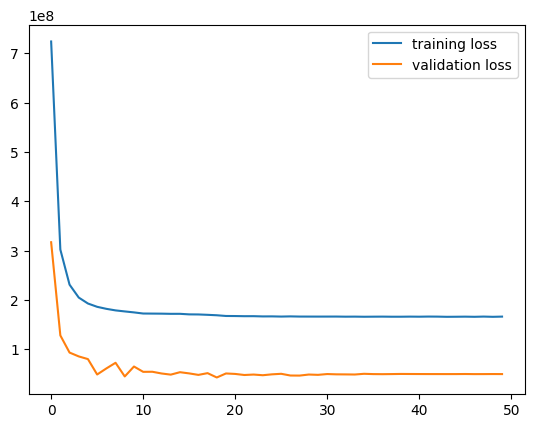

In [41]:
# Compile model
from keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    ## weight dacay on specific epochs   
    if epoch % 10 == 0:
        lr = lr * 0.1
    return lr
lr_scheduler = LearningRateScheduler(decay_schedule)

opt = optimizers.Adam(learning_rate=0.1)
model.compile(loss='mae', optimizer=opt)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks = [lr_scheduler])

# Plot training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


CNN

---



رای بهبود مدل CNN، می‌توانید با اضافه کردن لایه‌های جدید، قابلیت مدل برای تشخیص الگوهای پیچیده‌تری را افزایش دهید. به عنوان مثال، می‌توانید یک یا چند لایه Conv1D و یا LSTM اضافه کنید. همچنین، می‌توانید تعداد فیلترها را برای هر لایه افزایش دهید تا مدل بیشتر به جزئیات داده‌ها توجه کند.

به عنوان مثال، کد زیر یک مدل CNN با دو لایه Conv1D، یک لایه LSTM، یک لایه Dropout و دو لایه Dense با تعداد نورون‌های بیشتر نسبت به مدل قبلی است:

Epoch 1/50
3990/3990 [==============================] - 54s 13ms/step - loss: 1274199680.0000 - val_loss: 1223767936.0000 - lr: 1.0000e-03
Epoch 2/50
3990/3990 [==============================] - 52s 13ms/step - loss: 1091994496.0000 - val_loss: 911082816.0000 - lr: 1.0000e-03
Epoch 3/50
3990/3990 [==============================] - 50s 12ms/step - loss: 616066560.0000 - val_loss: 256793936.0000 - lr: 1.0000e-03
Epoch 4/50
3990/3990 [==============================] - 50s 12ms/step - loss: 141978736.0000 - val_loss: 20112516.0000 - lr: 1.0000e-03
Epoch 5/50
3990/3990 [==============================] - 52s 13ms/step - loss: 126243360.0000 - val_loss: 21089172.0000 - lr: 1.0000e-03
Epoch 6/50
3990/3990 [==============================] - 49s 12ms/step - loss: 125823984.0000 - val_loss: 21343306.0000 - lr: 1.0000e-03
Epoch 7/50
3990/3990 [==============================] - 47s 12ms/step - loss: 125559872.0000 - val_loss: 21922928.0000 - lr: 1.0000e-03
Epoch 8/50
3990/3990 [====================

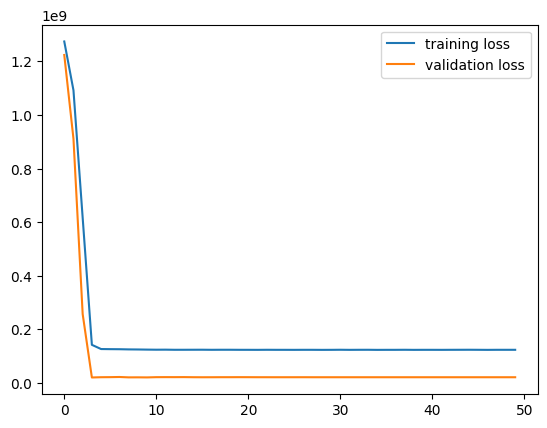

In [25]:
from keras.layers import LSTM

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile model
opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=opt)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[lr_scheduler])

# Plot training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


ن کد از نظر بازاری به منظور تجزیه و تحلیل داده‌های فروش محصولات به کار می‌رود. برای این منظور، این کد از الگوریتم K-means برای تقسیم داده‌ها به چند خوشه استفاده می‌کند. در اینجا، داده‌های فروش محصولات بر اساس تعداد فروش (Quantity) گروه‌بندی شده و سپس با استفاده از الگوریتم K-means به چهار خوشه تقسیم شده‌اند. نمودار پراکندگی بر روی این داده‌ها رسم شده است و در آخر با استفاده از یک نمودار دایره‌ای، توزیع داده‌های هر خوشه نمایش داده شده است. این اطلاعات به بازاریاب‌ها و مدیران کسب و کار کمک می‌کند تا فروش محصولات را بهتر مدیریت کنند و برنامه‌های بازاریابی را بهتر طراحی کن

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


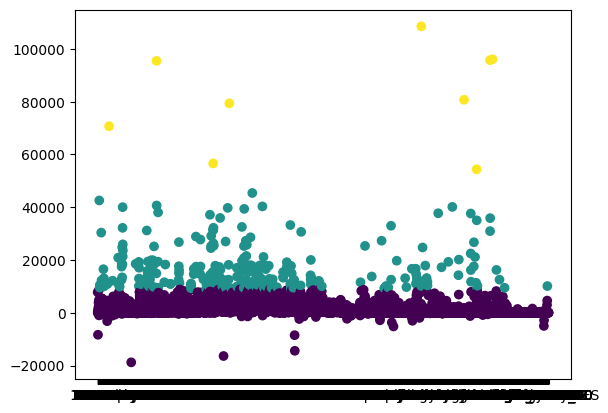

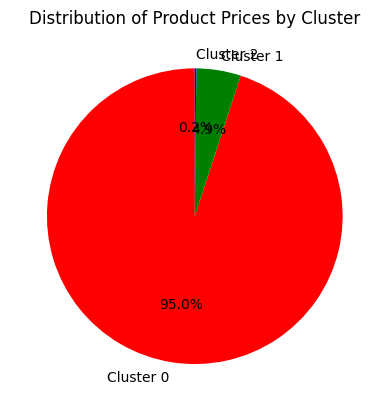

In [26]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/drive/MyDrive/398402/online_retail_II.csv', encoding='ISO-8859-1')

# Group data by CustomerID and calculate total amount of sales for each customer
customer_data = data.groupby('StockCode')['Quantity'].sum().reset_index()

# Prepare data for K-means algorithm
X = customer_data[['Quantity']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train K-means model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_scaled)

# Add cluster labels to the data
customer_data['Cluster'] = kmeans.labels_

# Plot the clusters
plt.scatter(customer_data['StockCode'], customer_data['Quantity'], c=customer_data['Cluster'])
plt.show()

# Create a Pie Chart to show the distribution of data
plt.pie(customer_data.groupby('Cluster').size(), labels=['Cluster 0', 'Cluster 1','Cluster 2'], colors=['red', 'green', 'blue', 'purple'], autopct='%1.1f%%', startangle=90)

# Add a title to the chart
plt.title('Distribution of Product Prices by Cluster')

# Show the chart
plt.show()




در این کد، یک تحلیل خوشه‌بندی بر روی داده‌های مربوط به فروش کالاها در هر کشور صورت گرفته است. ابتدا داده‌ها براساس کشور گروه‌بندی شده و مجموع قیمت فروش کالاهای هر کشور محاسبه شده است. سپس از الگوریتم خوشه‌بندی K-means برای تقسیم داده‌ها به چهار خوشه استفاده شده است. سپس با رسم نمودار پراکندگی برای داده‌ها در هر کشور و با استفاده از رنگ‌های متفاوت برای نمایش هر خوشه، مشاهده شده است که کشورهای مختلف چگونه در چهار خوشه مختلف تقسیم شده‌اند. در نهایت، با رسم یک نمودار دایره‌ای (Pie Chart) نشان داده شده است که هر چهار خوشه چه مقدار از کل داده‌ها را شامل می‌شود. این کار به تحلیل داده‌ها و درک بهتر از وضعیت فروش کالاها در هر کشور کمک می‌کند.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


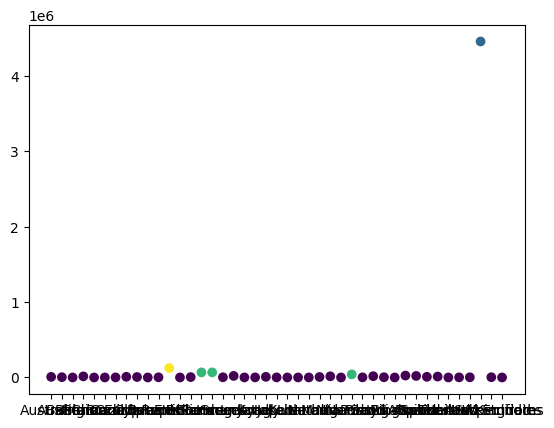

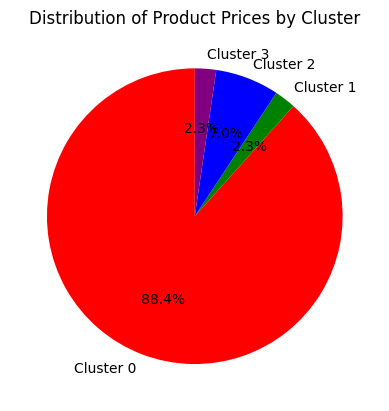

In [27]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/drive/MyDrive/398402/online_retail_II.csv', encoding='ISO-8859-1')

# Group data by CustomerID and calculate total amount of sales for each customer
customer_data = data.groupby('Country')['Price'].sum().reset_index()

# Prepare data for K-means algorithm
X = customer_data[['Price']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train K-means model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_scaled)

# Add cluster labels to the data
customer_data['Cluster'] = kmeans.labels_

# Plot the clusters
plt.scatter(customer_data['Country'], customer_data['Price'], c=customer_data['Cluster'])
plt.show()

# Create a Pie Chart to show the distribution of data
plt.pie(customer_data.groupby('Cluster').size(), labels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'], colors=['red', 'green', 'blue', 'purple'], autopct='%1.1f%%', startangle=90)

# Add a title to the chart
plt.title('Distribution of Product Prices by Cluster')

# Show the chart
plt.show()



می توانید بررسی کنید که مشتریان در چه زمان هایی از سال بیشترین سفارشات را داده اند، چه محصولاتی را بیشترین تعداد سفارش داده اند و چه کشورهایی بیشترین تعداد سفارش را داده اند

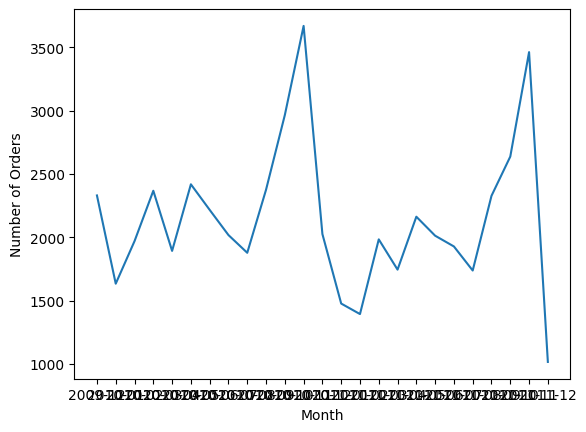

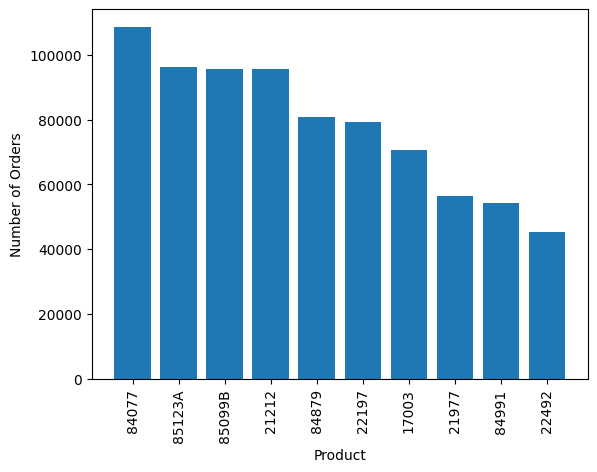

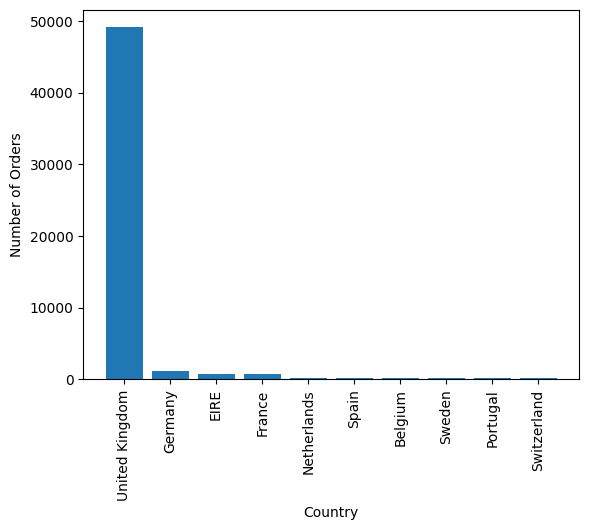

In [28]:
# Load data from CSV file
data = pd.read_csv('/content/drive/MyDrive/398402/online_retail_II.csv', encoding='ISO-8859-1')

# Convert InvoiceDate column to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')

# Extract month and year from InvoiceDate
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Group by YearMonth and count the number of orders
orders_by_month = data.groupby('YearMonth')['Invoice'].nunique()

# Plot the number of orders by month
plt.plot(orders_by_month.index.astype(str), orders_by_month.values)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

# Group by StockCode and count the number of orders
orders_by_product = data.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False)[:10]

# Plot the top 10 products by the number of orders
plt.bar(orders_by_product.index, orders_by_product.values)
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.ylabel('Number of Orders')
plt.show()

# Group by Country and count the number of orders
orders_by_country = data.groupby('Country')['Invoice'].nunique().sort_values(ascending=False)[:10]

# Plot the top 10 countries by the number of orders
plt.bar(orders_by_country.index, orders_by_country.values)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.show()
